In [1]:
import json, requests, time
from sqlalchemy import create_engine
import pandas as pd

engine = create_engine('postgresql://postgres:argmax@pg:5432/postgres')


# Data
Every time a user opens a mobile app, an auction is going on behind the scenes. The highest bidder gets to advertise his ad to the user.
## Auctions Table

In [2]:
sql_query = 'SELECT * FROM auctions;'
with engine.connect() as db_con:
    df = pd.read_sql(sql_query, con=db_con)
df

,id,eventTimestamp,unitDisplayType,brandName,bundleId,countryCode,deviceId,osAndVersion,bidFloorPrice,sentPrice
0,1,1657758857892,rewarded,Generic,com.loop.match3d,US,6a0a94554cf,Android-4.0,0.05,0.06
1,2,1657210707978,interstitial,Generic,com.loop.match3d,ZA,6a0b0e59f45,Android-4.0,0.01,0.16
2,3,1657392939412,interstitial,Motorola,com.YayySAL.DodgeAgent,BR,6a0fa820c46,Android-10.0,0.05,0.06
3,4,1657386816882,interstitial,Huawei,com.tintash.nailsalon,IQ,6a142bdbea2,Android-9.0,0.01,0.05
4,5,1657211600823,banner,Generic,com.tilegarden.match3,US,6a16943a771,Android-4.0,0.01,0.03
...,...,...,...,...,...,...,...,...,...,...
41579,41580,1657731605063,banner,Generic,com.tilegarden.match3,NZ,80edf5837e8,Android-4.0,0.01,0.02
41580,41581,1657657131101,interstitial,Apple,1436213906,VN,80ee6a5eebf,iOS-13.6,0.01,0.90
41581,41582,1657156070854,rewarded,Generic,com.loop.match3d,US,80efe531afc,Android-4.0,0.05,0.69
41582,41583,1657659603568,banner,Apple,1502447854,US,80f02dd397f,iOS-15.0,0.01,0.10


## App Vectors table
We've gathered the first few sentences from the app store description and embedded it with a [model](https://huggingface.co/mixedbread-ai/mxbai-embed-large-v1)

In [3]:
sql_query = f'''
SELECT
    *
FROM app_vectors
'''
has_embedding = False
while not has_embedding:
    with engine.connect() as db_con:
        df = pd.read_sql(sql_query, con=db_con)
    has_embedding = (~df["embedding"].isna()).all()
    if not has_embedding:
        print("Waiting for embeddings...")
        time.sleep(15)

df

,id,bundleId,content,embedding
0,1,com.loop.match3d,"Get ready for a new, challenging and original ...","[0.31683633,0.6250093,-0.120355725,0.2174227,-..."
1,2,com.YayySAL.DodgeAgent,"Your mission, should you choose to accept it, ...","[0.54112935,0.7446765,-0.58174425,0.9596788,0...."
2,3,com.tintash.nailsalon,It is manicure madness over here and it�s your...,"[0.31176743,0.60594726,-1.1395669,0.07631005,-..."
3,4,com.tilegarden.match3,\nIf you enjoy playing Match 3 tile & mahjong ...,"[0.050924387,1.0967343,-0.30831495,0.13220492,..."
4,6,com.AppIdeas.LevelUpRunner,"Are you a real hero? Are you the strongest, th...","[0.8975629,0.46442613,-0.18019181,1.2617054,0...."
5,17,1582745578,Dominate the coal industry and become the next...,"[0.88490516,0.6585199,-0.338669,0.18323605,0.5..."
6,18,1569586264,Choose the appropriate outfit to make it throu...,"[0.20005374,0.36083454,-0.1379232,0.3430872,-0..."
7,5,com.kamilbilge.ropesavior3d,Become the hero we need in this tangled puzzle...,"[0.51124793,0.5128076,-0.056303732,1.2819327,0..."
8,7,se.ace.fishinc,Gather your riches and travel across the open ...,"[0.7309438,0.41121796,-0.61960036,0.5350135,0...."
9,8,com.volt.dresstoimpress,\nChoose the appropriate outfit to make it thr...,"[0.20005357,0.36083442,-0.13792296,0.34308693,..."


We can use the `<=>` operator to run vector search within the database

In [4]:

vec = json.loads(df.embedding[0]) # get the first embedding
print ("Embedding size: {l}".format(l=len(vec)))

sql_query = f'''
SELECT
    *
FROM app_vectors
ORDER BY embedding<=>'{json.dumps(vec)}'
'''
with engine.connect() as db_con:
    df = pd.read_sql(sql_query, con=db_con)

df

Embedding size: 1024


,id,bundleId,content,embedding
0,1,com.loop.match3d,"Get ready for a new, challenging and original ...","[0.31683633,0.6250093,-0.120355725,0.2174227,-..."
1,12,1502447854,"Get ready for a new, challenging and original ...","[0.29414183,0.6344754,-0.038190607,0.21263401,..."
2,10,1529614832,Are you a fan of match-three & matching games?...,"[0.362127,0.8391744,-0.3356719,0.0013334347,-1..."
3,4,com.tilegarden.match3,\nIf you enjoy playing Match 3 tile & mahjong ...,"[0.050924387,1.0967343,-0.30831495,0.13220492,..."
4,5,com.kamilbilge.ropesavior3d,Become the hero we need in this tangled puzzle...,"[0.51124793,0.5128076,-0.056303732,1.2819327,0..."
5,15,1579489488,Become the hero we need in this tangled puzzle...,"[0.51124793,0.5128076,-0.056303732,1.2819327,0..."
6,13,1436213906,Gather your riches and travel across the open ...,"[0.8503366,0.3483968,-0.6132452,0.55295014,0.0..."
7,16,1586795332,"Are you a real hero? Are you the strongest, th...","[0.8975629,0.46442613,-0.18019181,1.2617054,0...."
8,6,com.AppIdeas.LevelUpRunner,"Are you a real hero? Are you the strongest, th...","[0.8975629,0.46442613,-0.18019181,1.2617054,0...."
9,7,se.ace.fishinc,Gather your riches and travel across the open ...,"[0.7309438,0.41121796,-0.61960036,0.5350135,0...."


# What you need to do
## The hypothesis
We assume that apps with similar desciptions, would have a similar asking price in the auctions (`sentPrice` column).

Use cosine similarity (`<=>`) on the embeddings to find similar apps, and any statistical tools you find suitable to prove or disprove this hypothesis.

## Is it consistent?
There are several other features in the auctions table (such as `CountryCode` and `OS`), 
Do your findings hold for those as well?

In [5]:
# TODO: Please write your analysis here

# My approch for tackling this challange:
## I employed three different methods for the analysis of this Hypothesis

1) Dimensionality reduction and visulization
2) Corelation coefficent calculation
3) Regression and R^2 calculation

In [6]:
!pip install scikit-learn
!pip install matplotlib

In [7]:
from scipy import stats
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from tqdm import trange
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

In [8]:
# General Functions Section

# this func return a data frame with all the auctions
def get_auctions_data():
    sql_query = 'SELECT * FROM auctions;'
    with engine.connect() as db_con:
        df = pd.read_sql(sql_query, con=db_con)
    return df


# this func returns a dataframe with all the apps data with the duplicates dropped
def get_apps_data():
    sql_query = f'''
    SELECT
        *
    FROM app_vectors
    '''
    has_embedding = False
    while not has_embedding:
        with engine.connect() as db_con:
            df = pd.read_sql(sql_query, con=db_con)
        has_embedding = (~df["embedding"].isna()).all()
        if not has_embedding:
            print("Waiting for embeddings...")
            time.sleep(15)
    df = df.sort_values("id")
    return df.drop_duplicates("bundleId").dropna()
    
## this func calculates and returns the mean of each apps sentPrice and returns a dictionary
def get_apps_means():
    sql_query = 'SELECT * FROM auctions;'
    with engine.connect() as db_con:
        df = pd.read_sql(sql_query, con=db_con)
        
    df = df[["bundleId", "sentPrice"]]
    means = df.groupby(['bundleId']).mean()
    means = means.sort_values("sentPrice")
    return {means.iloc[i].name:means.iloc[i].sentPrice for i in range(len(means))}

#this func returns a ordered dataframe with the apps that are most similar to the app with id, with duplicated apps droped
def get_similar_apps(id=1):
    df = get_apps_data()
    vec = json.loads(df[df.id == id].embedding.iloc[0]) # get the embedding of id

    sql_query = f'''
    SELECT
        *
    FROM app_vectors
    ORDER BY embedding<=>'{json.dumps(vec)}'
    '''
    with engine.connect() as db_con:
        sorted_df = pd.read_sql(sql_query, con=db_con)
    # sorted_df = sorted_df.sort_values("bundleId")
    return sorted_df.drop_duplicates("bundleId").dropna()
    # return sorted_df.dropna()

# this func returns a ([num of diffrent apps],1024) ndarray of the app embeddings in flaot, the array is in order of id if no df is given otherwise in original order
def get_app_embeddings(apps_df=None):
    if apps_df is None:
        apps_df = get_apps_data().sort_values("id")
    apps_df = apps_df["embedding"].str.strip("'[ ]")    #todo refactor with df.value
    app_embeds = np.fromstring(apps_df.iloc[0], sep=',')
    for i in range(1, len(apps_df)): 
        temp_embed = np.fromstring(apps_df.iloc[i], sep=',')
        app_embeds = np.vstack([app_embeds, temp_embed])
    return app_embeds

pd.options.mode.chained_assignment = None # to remove pandas sliceing warning msg

# 1) Dimensionality reduction and visulization
## Firstly to get a more intutive sense of the data I set out to visulize the data in a 2d plane and look for clusters or priceing diffrences

Text(0.5, 1.0, 'reduced app embedings with color as mean sentPrice')

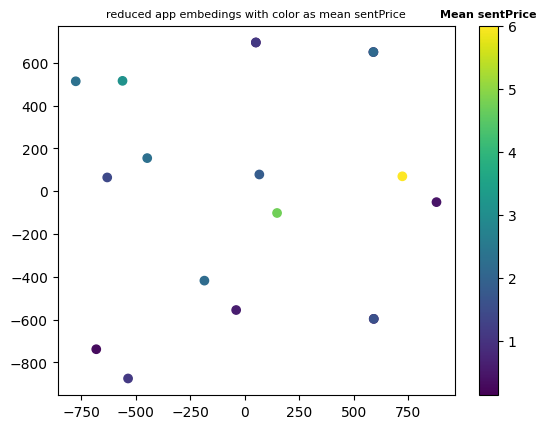

In [9]:
# visulizing embedding simularity
# dimension reduction of embeddings
means_dict = get_apps_means()
apps_df = get_apps_data().sort_values("id")
colors_sentPrice = np.asarray([means_dict[x] for x in apps_df.bundleId])
embeds = get_app_embeddings()

pca = PCA()
embeds_18d = pca.fit_transform(embeds)
embed_2d = TSNE(2,perplexity=5).fit_transform(embeds_18d)
embed_2d = embed_2d.T

norm = plt.Normalize(np.min(colors_sentPrice), min(6 ,np.max(colors_sentPrice))) ## largest mean sentPrice is 18 and next largest is 4.7 so I capped the color bar for better visulization of sentPrices
plt.scatter(embed_2d[0][:], embed_2d[1][:], c=colors_sentPrice, cmap='viridis', norm=norm)
cl = plt.colorbar()
cl.ax.set_title('Mean sentPrice', fontsize=8, fontweight='bold')
plt.title("reduced app embedings with color as mean sentPrice", fontsize=8)

Of course we lose data in the dimensionality reduction and so embedding which were 'close' in the original dimension may not be close in the 2d plane or vice versa.
Yet we can see that many of the apps (embeddings) that are closeare not close in their  mea  sentPrice (color), which may heuristicly imply that the hypothesis is wrong

# 2) Corelation coefficent calculation
## I would like to see what is the correlation between the apps cos simmilarity and their price diffrences
Idealy if the hypothsis is true then we would find that simmilar apps (large cos sim value) have small diffrences in their mean sentPrice

In [10]:
# this func returns a matrix of the cos similarity values, and a dict with the apps order in the matrix
def get_simmilaritys():
    sim_ls = get_similar_apps(1)
    embeds = get_app_embeddings(sim_ls)
    app_sim_order_dict = {name:i for i, name in enumerate(sim_ls.bundleId.tolist())}

    return cosine_similarity(embeds), app_sim_order_dict


# this func prosseses the data and returns an array containing the mean deltas between all the apps and an array with the cos sim between all the apps, so we can calculate the corrleation coficient
def prosses_data_for_corr():
    simmilarity_mat, app_sim_order_dict = get_simmilaritys()
    means_dict = get_apps_means()
    means_dif, cos_sim = [], []
    app_sim_order_ls = list(app_sim_order_dict.keys())
    
    for i, name_i in enumerate(app_sim_order_dict.keys()): # we dont want to record the diff between the app and itself and we dont want duplicates like app1-app2 & app2-app1
        for j in range(i+1, len(app_sim_order_dict)):
            cos_sim.append(simmilarity_mat[i][j])
            means_dif.append(abs(means_dict[name_i] - means_dict[app_sim_order_ls[j]]))
    return np.asarray(cos_sim), np.asarray(means_dif)

PearsonRResult(statistic=-0.06331832767064471, pvalue=0.43682714256747185)
SignificanceResult(statistic=-0.06828978994995442, pvalue=0.4016092971661287)


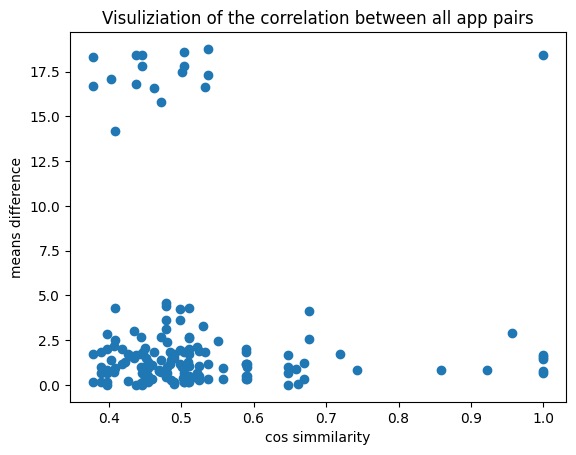

In [11]:
cos_sim, means_dif = prosses_data_for_corr()

plt.scatter(cos_sim, means_dif)
plt.xlabel("cos simmilarity")
plt.ylabel("means difference")
plt.title("Visuliziation of the correlation between all app pairs")
print(stats.pearsonr(cos_sim, means_dif))
print(stats.spearmanr(cos_sim, means_dif))

from what we can see both the pearson and spearman correlations are very close to zero and so the correlation is relatively weak between the cos sim and the price difference, although the p value is fairly large (not significant) which weakens the conclusions we can derive from this analysis.
We can also see in the plot that there isn't much correlation

# 3) Regression and R^2 calculation
## I want to undrstand how much of the variance in sentPrice can be explained by the app vectors using R^2
I chose to use the vector embeddings because they hold much more information then the cos similarities where the information of two vectors is are reduced to a scaler. 

In [12]:
# this is a helper func to turn the column of embeddings from a str column to a ndarray of floats
def parse_embeds(row):
    row = np.array(row.strip("[]'").split(","), dtype=float).tolist()
    return row

# this helper func parses the osAndVersion column into to seprate columns
def parse_os_version(entry):
    os, version = entry.split('-')
    version =  version[:max(version.find(".") + 1, 2)]

    return os, float(version)
  

# this func does the preprossesing of the additional features: osAndsVersion, unitDisplayType and bidFloorPrice
def process_other_features(df):
    df_one_hot_display_type = pd.get_dummies(df.unitDisplayType, dtype=float) # creating one hot vectors for unitdisplayType
    df[['os', 'Version']] = df['osAndVersion'].apply(parse_os_version).tolist()
    df_one_hot_os = pd.get_dummies(df.os, dtype=float, drop_first=True) # creating one hot vectors for oS
    df = df.drop(["osAndVersion", "os", "unitDisplayType"],axis=1)
    return pd.concat([df, df_one_hot_os, df_one_hot_display_type], axis=1)
    
    
# this func returns an ndarray with of the embeddings in float format of shape (40k,1024) and a
# dataframe with a columns [bundleId, sentPrice, embedding] for each row in the auctions db, the embedding matches the bundleId
# if use_others is true the returned data will contain the additional features, if use_embeddings is true the data will contain the app embedings
def get_preprocessing_for_regression(use_others=True, use_embeddings=True):
    sql_query = f'''

    SELECT "auctions"."bundleId", 
        "auctions"."sentPrice", 
        "auctions"."unitDisplayType", 
        "auctions"."bidFloorPrice",
        "auctions"."osAndVersion", 
        "app_vectors"."embedding"
    FROM "auctions"
    JOIN "app_vectors" ON "auctions"."bundleId" = "app_vectors"."bundleId"; 
    '''
    has_embedding = False
    while not has_embedding:
        with engine.connect() as db_con:
            df = pd.read_sql(sql_query, con=db_con)
        has_embedding = (~df["embedding"].isna()).all()
        if not has_embedding:
            print("Waiting for embeddings...")
            time.sleep(15)
    other_feat = pd.DataFrame([])
    if use_others:
        other_feat = process_other_features(df[["osAndVersion", "unitDisplayType", "bidFloorPrice"]])
    if use_embeddings:
        X = df["embedding"].apply(parse_embeds)
        X = X.to_list()
        X = np.vstack(X)
        merged = pd.concat([pd.DataFrame(X), other_feat],axis=1)
        return merged.to_numpy(), df["sentPrice"].to_numpy()
    return other_feat.to_numpy(), df["sentPrice"].to_numpy()


# this func receives the data ,fits the model and prints it's R^2 score
def train_and_eval_model(X, targets, msg):
    x_train, x_test, y_train, y_test = train_test_split(X, targets, test_size=0.2)
    reg_r = RandomForestRegressor(n_estimators=10, max_depth=5) # to avoid overfitting
    reg_r.fit(x_train, y_train)
    print(f"the R^2 score for model trained on {msg} : {reg_r.score(x_test, y_test)}")

## further analysis :
I wanted to check whether other features in the auction data could be beneficial in predicting the sentPrice (explaining more of the variance).
I found that the features countryCode and brandname had too many catagorical columns which bloated the model too much and lead to poor preformance.
So I did the following:

I) Vector embeddings alone

II) Additional features alone

III) Vector embeddings and additional features

In [13]:
#  I) regression using only the app vectors
X, targets = get_preprocessing_for_regression(use_others=False,use_embeddings=True)
train_and_eval_model(X, targets, "app embeddings only")

the R^2 score for model trained on app embeddings only : 0.03005975892693591


In [14]:
# II) regression using aditional features only
X_other, targets = get_preprocessing_for_regression(use_others=True,use_embeddings=True)
train_and_eval_model(X_other, targets, "additional features only")

the R^2 score for model trained on additional features only : 0.09969706833479786


In [15]:
# III) regression using app vectors and aditional features
X_other, targets = get_preprocessing_for_regression(use_others=True,use_embeddings=True)
train_and_eval_model(X_other, targets, "app embeddings and additional features")

the R^2 score for model trained on app embeddings and additional features : 0.06314500030879666


## In conclusion
my results:

(I) the R^2 score for model trained on app embeddings only : 0.02239438789323156

(II) the R^2 score for model trained on additional features only : 0.07772163414799416
(III) the R^2 score for model trained on app embeddings and additional features : 0.10704747326705599

These results are relatively low and very close, and their order may change based on randomness.

The coefficient of determination (R^2) is defined as the proportion of the variation in the dependent variable (sentPrice) that is predictable from the independent variables (app embeddings), and so if the hypothesis were true, we would expect (I) to be higher. And so, from these results and from the lack of correlation between cos similarities and the app's mean sentPrice differences that I found in method 2, I conclude that the hypothesis that similar apps have similar asking prices is incorrect.

This is also consistent when we used additional features in the consideration, as seen in (II) and (III). We still weren't able to explain a significant amount of the variance in sentPrices. Interestingly, (II) doing better than (I) further illustrates that app similarities do not have a large role in the app's asking prices to 